# Assignment — Generative network models

In [1]:
import matplotlib.pyplot as plt
import requests
from zlib import adler32
import networkx as nx
from tqdm.notebook import tqdm
from scipy.stats import ks_2samp
import numpy as np
import random
import scipy.stats as st

### Task 1. Erdos-Renyi model (0 points)

Implement Erdos Renyi model (random graph) — each pair of $n$ nodes are connected with some fixed probability $p$.

In [2]:
def erdos_renyi_graph(n, p):
    G = nx.Graph()
    nodes = np.arange(n)
    G.add_nodes_from(nodes)
    G.add_edges_from(random_edges(nodes, p))
    return G

Write a function `random_edges` with parameters: `nodes` — np.array of nodes, for example [1, 2, 3, 4, ...] and `p` — probability of connection. The function returns np.array with tuples of the form [(1, 2), (2, 4), ...], where 1-2, 2-4 are edges that should be added in the graph.

*Hint: To speed up the generation, look at ALG.1 in the article [Efficient generation of large random networks](http://vlado.fmf.uni-lj.si/pub/networks/doc/ms/rndgen.pdf).*

In [3]:
def random_edges(nodes, p):
    # YOUR CODE HERE
    edges = []
    v, w = 1, -1
    n = len(nodes)
    while v < n:
      r = np.random.uniform(size=1)
      w = int(w + 1 + np.log(1 - r) / np.log(1 - p))
      while w >= v and v < n:
        w -= v
        v += 1
      if v < n:
        edges.append((v, w))
    return np.array(edges)
    # raise NotImplementedError()

#def random_edges(nodes, p):
#    # YOUR CODE HERE
#    rmatrix = np.random.rand(len(nodes), len(nodes))
#    row_ids, col_ids = np.where(rmatrix <= p)
#    mask = row_ids > col_ids
#    return np.stack([row_ids[mask], col_ids[mask]]).T
#    # raise NotImplementedError()

In [4]:
'''Check the Erdos-Renyi random graph generation'''
assert len(erdos_renyi_graph(100, 0.1).edges) > 0
n = 100
p = 0.4
n_edges = n * (n-1) / 2
q = 1 - p
sigma = np.sqrt((p * q) / n_edges)
assert  p - 3*sigma < random_edges(np.arange(n), p).shape[0] / n_edges < p + 3*sigma
n = 1000
p = 0.01
n_edges = n * (n-1) / 2
q = 1 - p
sigma = np.sqrt((p * q) / n_edges)
assert  p - 3*sigma < random_edges(np.arange(n), p).shape[0] / n_edges < p + 3*sigma
n = 300
p = 0.9
n_edges = n * (n-1) / 2
q = 1 - p
sigma = np.sqrt((p * q) / n_edges)
assert  p - 3*sigma < random_edges(np.arange(n), p).shape[0] / n_edges < p + 3*sigma

Let us draw a couple of generated graphs

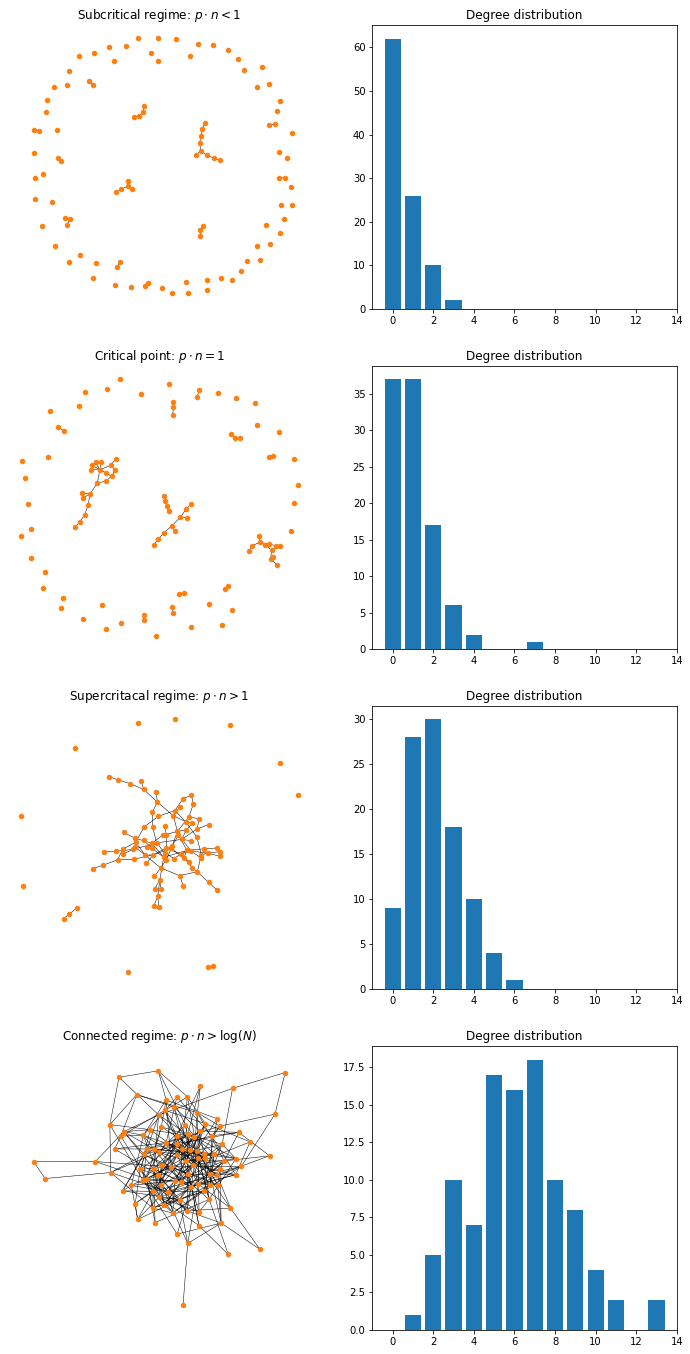

In [5]:
n = 100
cases = [('Subcritical regime: $p \cdot n < 1$', n, 0.5/n), 
         ('Critical point: $p \cdot n = 1$', n, 1/n), 
         ('Supercritacal regime: $p \cdot n > 1$', n, 2/n), 
         ('Connected regime: $p \cdot n > \log(N)$', n, 6.5/n)]
plt.figure(figsize=(12, 6 * 4))
i = 1
for regime, n, p in cases:
    plt.subplot(4, 2, i)
    G = erdos_renyi_graph(n, p)
    nx.draw(
        G, 
        with_labels=False, 
        node_size=20, 
        width=0.5, 
        node_color='tab:orange')
    plt.title(regime)
    i += 1
    plt.subplot(4, 2, i)
    degree_seq = [degree for (node, degree) in G.degree]
    bins, freq = np.unique(degree_seq, return_counts=True)
    plt.bar(bins, freq)
    plt.xlim((-1, 14))
    plt.title('Degree distribution')
    i += 1

### Task 2. Fitting parameters of Erdos-Renyi model (0 points)

In the Erdos-Renyi model, we can estimate a degree distribution using the binomial distribution. The binomial distribution $B(n, p)$ converges to the Poisson $\text{Pois}(\lambda)$ when the number of samples $n$ tends to infinity with the fixed product $np = \lambda$.

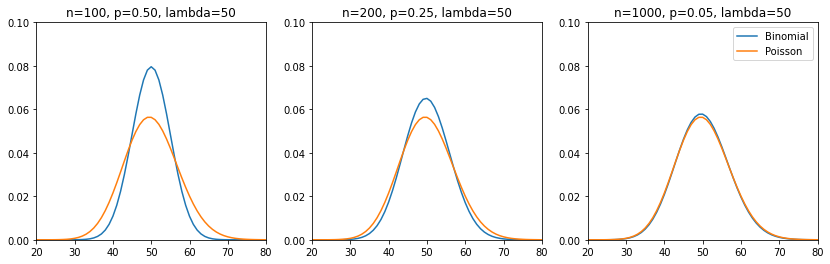

In [6]:
plt.figure(figsize=[14, 4])
for i, [n, mean] in enumerate([[100, 50], [200, 50], [1000, 50]]):
    plt.subplot(1, 3, i+1)
    plt.plot(st.binom(n, mean / n).pmf(np.arange(100)), 
             label="Binomial")
    plt.plot(st.poisson(mean).pmf(np.arange(100)), 
             label="Poisson")
    plt.xlim(20, 80)
    plt.ylim(0, 0.1)
    plt.title('n={}, p={:.2f}, lambda={}'.format(n, mean / n, mean))
plt.legend(loc='upper right');

In this task we will estimate properties of Binomial and Poisson distributions and compare in what cases it is better to use Binomial.

Write a function `estimate_binomial` that takes a random graph and returns binomial parameters `n` and `p`.

In [7]:
def estimate_binomial(G):
    # YOUR CODE HERE
    n = len(G.nodes)
    max_n_edges = n * (n - 1) / 2
    n_edges = len(G.edges)
    p = n_edges / max_n_edges
    return n, p
    # raise NotImplementedError()

In [8]:
G = erdos_renyi_graph(100, 0.5)
n, p = estimate_binomial(G)
assert abs(p - 0.5) <= 0.05
assert n == 100

Write a function `estimate_poisson` that takes a random graph and returns the Poisson parameter $\lambda$ (here denoted as `m`).

In [9]:
def estimate_poisson(G):
    # YOUR CODE HERE
    n, p = estimate_binomial(G)
    return n*p
    # raise NotImplementedError()

In [10]:
G = erdos_renyi_graph(1000, 0.05)
m = estimate_poisson(G)
assert abs(m - 50) <= 1

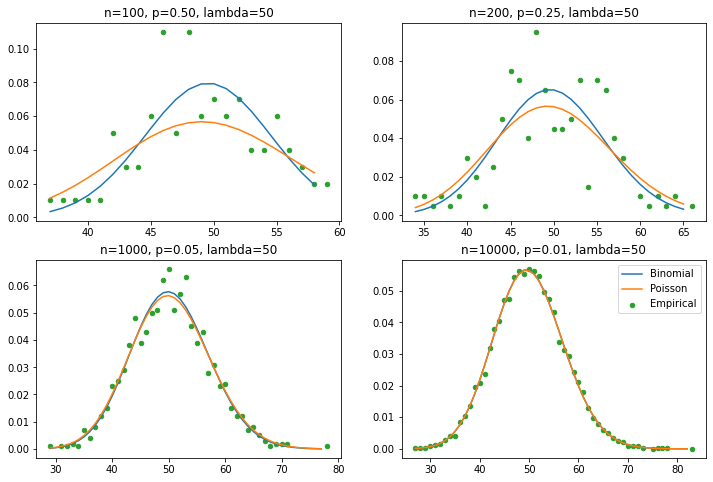

In [11]:
plt.figure(figsize=[12, 8])
for i, [n, p] in enumerate([[100, 0.5], [200, 0.25], [1000, 0.05], [10000, 0.005]]):
    plt.subplot(2, 2, i+1)
    G = erdos_renyi_graph(n, p)
    degree_density = np.array(nx.degree_histogram(G)) / n
    idx = np.argwhere(degree_density > 0)
    plt.scatter(idx, degree_density[idx], label="Empirical", c='tab:green', s=20)
    degrees = dict(G.degree).values()
    k_space = np.arange(min(degrees), max(degrees))
    plt.plot(k_space, st.binom(*estimate_binomial(G)).pmf(k_space), label="Binomial")
    plt.plot(k_space, st.poisson(estimate_poisson(G)).pmf(k_space), label="Poisson")
    plt.title(f'n={n}, p={p:.2f}, lambda={n*p:.0f}')
plt.legend()
plt.show()

### Task 3. Degree distribution in random graphs (1 points)

In [12]:
url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/wiki_vote.txt'
open('wiki_vote.txt', 'wb').write(requests.get(url).content)

url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/facebook_combined.txt'
open('facebook_combined.txt', 'wb').write(requests.get(url).content)

url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/collaboration_network_of_arxiv_general_relativity_category.txt'
open('collaboration_network_of_arxiv_general_relativity_category.txt', 'wb').write(requests.get(url).content);


Let us compare degree distributions of real and random networks and decide whether they are close or not.

Write a function `random_from_real` that takes a graph and returns a random network that has the same average node degree and the same number of nodes as a given network. 

In [13]:
def random_from_real(graph):
    # YOUR CODE HERE
    nodes_n = len(graph.nodes)
    average_node_degree = np.mean(list(dict(graph.degree).values())) + 1
    G = nx.Graph()
    nodes = list(range(nodes_n))
    for i in range(1, int(average_node_degree/2) + 1):
        targets = nodes[i:] + nodes[:i]
        G.add_edges_from(zip(nodes, targets))
    return G
    # raise NotImplementedError()

In [14]:
for file in ['wiki_vote.txt', 
             'collaboration_network_of_arxiv_general_relativity_category.txt', 
             'facebook_combined.txt']:
    real_net = nx.read_edgelist(file)
    random_net = random_from_real(real_net)
    av_degree_random = np.mean(list(dict(random_net.degree).values()))
    av_degree_real = np.mean(list(dict(real_net.degree).values()))
    assert len(random_net) == len(real_net)
    assert np.abs(av_degree_random - av_degree_real) < 1

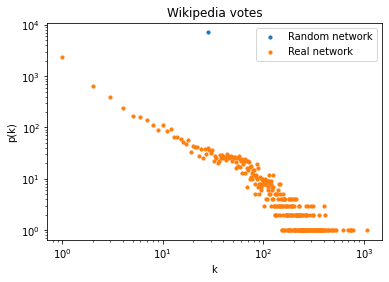

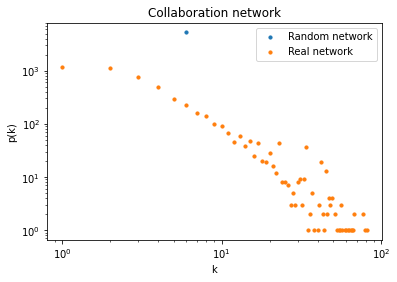

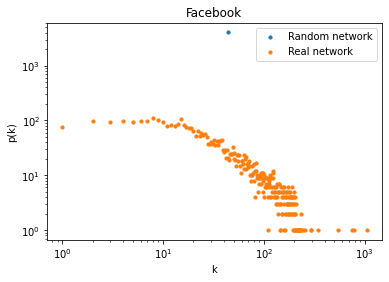

In [15]:
cases = [['Wikipedia votes', 'wiki_vote.txt'], 
         ['Collaboration network', 'collaboration_network_of_arxiv_general_relativity_category.txt'], 
         ['Facebook', 'facebook_combined.txt']]
for title, file in cases:
    real_net = nx.read_edgelist(file)
    random_net = random_from_real(real_net)
    degree_hist = np.array(nx.degree_histogram(random_net))
    idx = np.argwhere(degree_hist > 0)
    plt.scatter(idx, degree_hist[idx], s=10, label='Random network')
    degree_hist = np.array(nx.degree_histogram(real_net))
    idx = np.argwhere(degree_hist > 0)
    plt.scatter(idx, degree_hist[idx], s=10, label='Real network')
    plt.legend()
    plt.xlabel('k')
    plt.ylabel('p(k)')
    plt.title(title)
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

### Task 4. Giant component in random graphs (1 points)

Let us see how the size of small components (small — not giant) depends on the probability near the critical point: $p =1/n$.

Write a function `small_component_size` with parameters `n` — number of nodes, `probabilities` — np.array of probabilities. The function generates a random graph for each probability and returns np.array of average sizes of small components.

*Hint: to find nodes in components, use `nx.connected_components(graph)`*

In [16]:
def small_component_size(n, probabilities):
    # YOUR CODE HERE
    sc_sizes = []
    for p in probabilities:
      G = erdos_renyi_graph(n, p)
      sum_of_lens = 0
      for cc in nx.connected_components(G):
        if len(cc) < 100:
          sum_of_lens += len(cc)
      sc_sizes.append(sum_of_lens / nx.number_connected_components(G))
    return np.array(sc_sizes)
    #raise NotImplementedError()

In [17]:
n = 1000
p_space = np.linspace(0.01/n, 2.5/n, 50)
sizes = []
for _ in range(5):
    size = small_component_size(n, p_space)
    assert size.shape == (50,)
    sizes.append(size)

av_sizes = np.mean(sizes, axis=0)
assert av_sizes[0] < av_sizes[np.argmin(np.abs(p_space*n - 1))]
assert av_sizes[49] < av_sizes[np.argmin(np.abs(p_space*n - 1))]

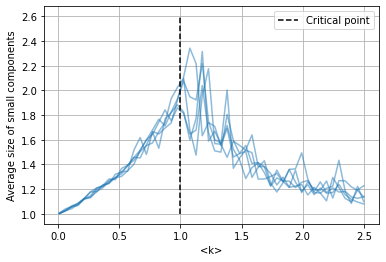

In [18]:
for i in range(5):
    plt.plot(p_space*n, sizes[i], c='tab:blue', alpha=0.5)
plt.plot([1, 1], [1, 2.6], 'k--', label='Critical point')
plt.xlabel('<k>')
plt.ylabel('Average size of small components')
plt.legend()
plt.grid()
plt.show()

Also let us see how the size of a giant component depends on the probability near the critical point.

Write a function `giant_component_size` with parameters `n` — number of nodes, `probabilities` — np.array of probabilities. The function generates a random graph for each probability and returns np.array of sizes of a giant component.

*Hint: to find nodes in a ginat component, use `max(nx.connected_components(graph), key=len)`*

In [19]:
def giant_component_size(n, probabilities):
   # YOUR CODE HERE
    sc_sizes = []
    for p in probabilities:
      G = erdos_renyi_graph(n, p)
      sc_sizes.append(len(max(nx.connected_components(G), key=len)))
    return np.array(sc_sizes)
    #raise NotImplementedError()

In [20]:
n = 1000
p_space = np.linspace(0.01/n, 2.5/n, 50)
sizes = []
for _ in range(5):
    size = giant_component_size(n, p_space)
    assert size.shape == (50,)
    sizes.append(size)

av_sizes = np.mean(sizes, axis=0)
assert av_sizes[0] < 20
assert 20 < av_sizes[np.argmin(np.abs(p_space*n - 1))] < 150
assert 700 < av_sizes[np.argmin(np.abs(p_space*n - 2))] < 900

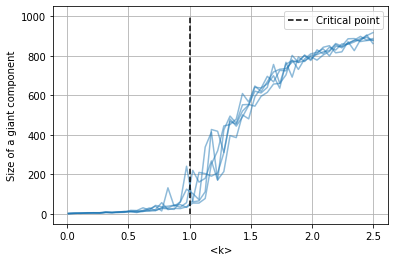

In [21]:
for i in range(5):
    plt.plot(p_space*n, sizes[i], c='tab:blue', alpha=0.5)
plt.plot([1, 1], [0, 1000], 'k--', label='Critical point')
plt.xlabel('<k>')
plt.ylabel('Size of a giant component')
plt.legend()
plt.grid()
plt.show()

### Task 5. Snobbish networks (2 points)

Consider a network of $N$ red and $N$ blue nodes. The probability that there is a link between nodes of identical color is $p$ and the probability that there is a link between nodes of different color is $q$. A network is snobbish if $p>q$, capturing a tendency to connect to nodes of the same color. For $q = 0$ the network has at least two components, containing nodes with the same color.

Write a function `snobbish_network` that takes the number of red (or blue) nodes `n`, probability of link between nodes of the same color `p` and probability of link between nodes of different color `q`. The function returns a network with $2N$ nodes where every node has an attribute `color` that can be `blue` or `red`.

*Hint: to set node attributes, use `nx.set_node_attributes`*

In [22]:
def snobbish_network(n, p, q):
    # YOUR CODE HERE
    G_r = nx.Graph()
    for i in range(n):
      G_r.add_nodes_from([(i, {"color": "red"})])
    G_r.add_edges_from(random_edges(G_r.nodes, p))

    G_b = nx.Graph()
    for j in range(n):
      G_b.add_nodes_from([(j, {"color": "blue"})])
    G_b.add_edges_from(random_edges(G_b.nodes, p))

    G = nx.disjoint_union(G_r, G_b)
    rmatrix = np.random.rand(2 * n, 2 * n)
    row_ids, col_ids = np.where(rmatrix <= q)
    mask = (row_ids > col_ids) & (row_ids >= n) & (col_ids < n)
    qmatrix =  np.stack([row_ids[mask], col_ids[mask]]).T
    G.add_edges_from(qmatrix)
    return G
    # raise NotImplementedError()

In [23]:
sn_net = snobbish_network(100, 0.1, 0.01)
assert sn_net.number_of_nodes() == 200
assert set(nx.get_node_attributes(sn_net, 'color').values()) == {'blue', 'red'}
assert np.sum(np.array(list(nx.get_node_attributes(sn_net, 'color').values())) == 'red') == 100
assert 0.76 < nx.attribute_assortativity_coefficient(sn_net, 'color') < 0.88
sn_net = snobbish_network(200, 0.1, 0.05)
assert 0.25 < nx.attribute_assortativity_coefficient(sn_net, 'color') < 0.4

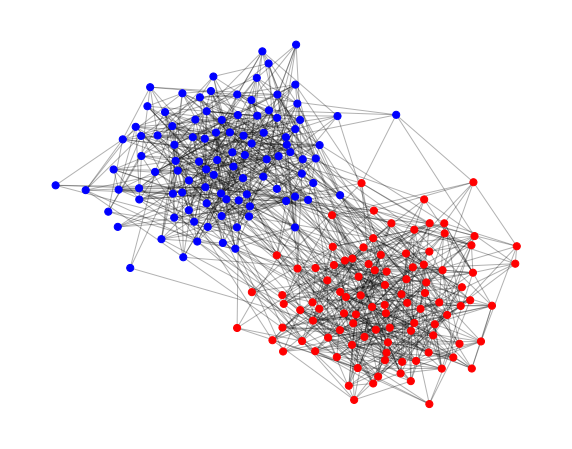

In [24]:
plt.figure(figsize=(10, 8))
sn_net = snobbish_network(100, 0.1, 0.01)
pos = nx.spring_layout(sn_net)
nx.draw_networkx_nodes(
    sn_net, 
    pos=pos,
    node_color=nx.get_node_attributes(sn_net, 'color').values(), 
    node_size=50)
nx.draw_networkx_edges(sn_net, pos=pos, alpha=0.3)
plt.axis('off')
plt.show()

### Task 6. Watts-Strogatz model (0 points)

Implement Watts-Strogatz model (small-world model) — rewire an edge with probability `p` in a ring lattice with `n` nodes and `k` degree.

In [25]:
def watts_strogatz_graph(n, k, p):
    G = ring_lattice(n, k)
    for node in G.nodes:
        rewire(G, node, k, p)
    return G

Write a function `ring_lattice` that returns a regular ring lattice with `n` nodes (0, 1, 2, ..., n-1) and `k` node degree. In a case of an odd node degree, it round it to the nearest smaller even number.

In [26]:
np.eye(6)

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]])

In [27]:
A = np.zeros([6, 6])
for i in range(4):
    A = A + np.eye(6)
    A = np.roll(A, 1, axis=0)
A

array([[0., 0., 1., 1., 1., 1.],
       [1., 0., 0., 1., 1., 1.],
       [1., 1., 0., 0., 1., 1.],
       [1., 1., 1., 0., 0., 1.],
       [1., 1., 1., 1., 0., 0.],
       [0., 1., 1., 1., 1., 0.]])

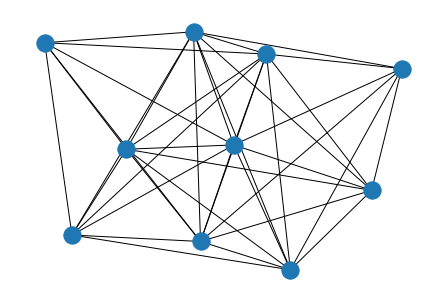

In [28]:
n = 10
k = 12
matrix = np.zeros([n, n])
for i in range(-k // 2, k // 2 + 1):
    if i != 0:
        matrix += np.eye(n, k=i)
nx.draw(nx.from_numpy_array(matrix))

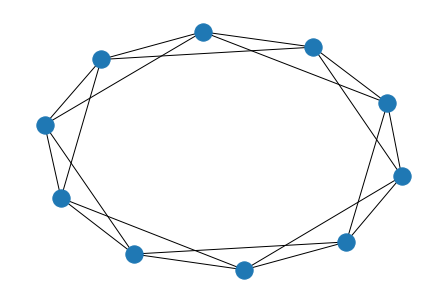

In [29]:
n = 10
k = 4
matrix = np.zeros([n, n])
for i in range(-k // 2, k // 2 + 1):
    if i != 0:
        matrix += np.roll(np.eye(n), i, axis=0)
nx.draw(nx.from_numpy_array(matrix))

In [30]:
def ring_lattice(n, k):
    # YOUR CODE HERE
    G = nx.Graph()
    nodes = list(range(n))
    for i in range(1, int(k/2 + 1)):
        targets = nodes[i:] + nodes[:i]
        G.add_edges_from(zip(nodes, targets))
    return G

    #A = np.zeros([n, n])
    #for i in range(int(-k / 2), int(k / 2 + 1)):
    #    if i != 0:
    #        A += np.roll(np.eye(n), i, axis=0)
    #return nx.from_numpy_array(A)

    # raise NotImplementedError()

In [31]:
assert nx.degree_histogram(ring_lattice(10, 2))[2] == 10
assert nx.degree_histogram(ring_lattice(10, 3))[2] == 10
assert nx.degree_histogram(ring_lattice(10, 4))[4] == 10

Write a function `rewire` that takes in input a ring lattice `G`, a `node`, a model parameter `k` and probability `p`. For every right hand side neighbor $i$, the function rewires an edge (`node`, $i$) into a random edge (`node`, $j$) with probability `p` where $i \neq j \neq $ `node`.

*Hints:*
* *Why do we only rewire right hand side edges? We want to guarantee that only untouched in previous iterations edges will be rewound. Look at the picture — we could not move the red edges in previous iterations.
![](https://raw.githubusercontent.com/netspractice/network-science/main/images/watts_strogatz_how_to_rewire.png)*
* *To speed up the generation, do not filter nodes to random selection. If a selected node produces an existing edge or a loop, just skip it.*

In [32]:
n = 10
k = 4

In [33]:
a = np.array(list(G.neighbors(2))) + n
a[a > n][:int(k/2)] % n

array([9, 6])

In [34]:
def rewire(G, node, k, p):
    # YOUR CODE HERE
    neighbors = (node + np.arange(1, int(k/2)+1)) % n
    for j in neighbors:
        if np.random.random() <= p:
            target = np.random.choice([x for x in range(n) if x != node])
            if not G.has_edge(node, target):
                G.remove_edge(node, j)
                G.add_edge(node, target)
    # raise NotImplementedError()

In [35]:
cases = [[50, 8, 0.1], 
         [1000, 10, 0.01],
         [1000, 10, 0.5],
         [1000, 10, 0.99]]
for n, k, p in cases:
    G = watts_strogatz_graph(n, k, p)
    assert nx.number_of_nodes(G) == n
    assert nx.number_of_edges(G) == int(k / 2 * n)
    degree_seq = [degree for (node, degree) in G.degree]
    nxG = nx.watts_strogatz_graph(n, k, p, 1)
    nxdegree_seq = [degree for (node, degree) in nxG.degree]
    assert ks_2samp(degree_seq, nxdegree_seq).pvalue > 0.05

Let us draw a small-world graph in some steps of the algorithm

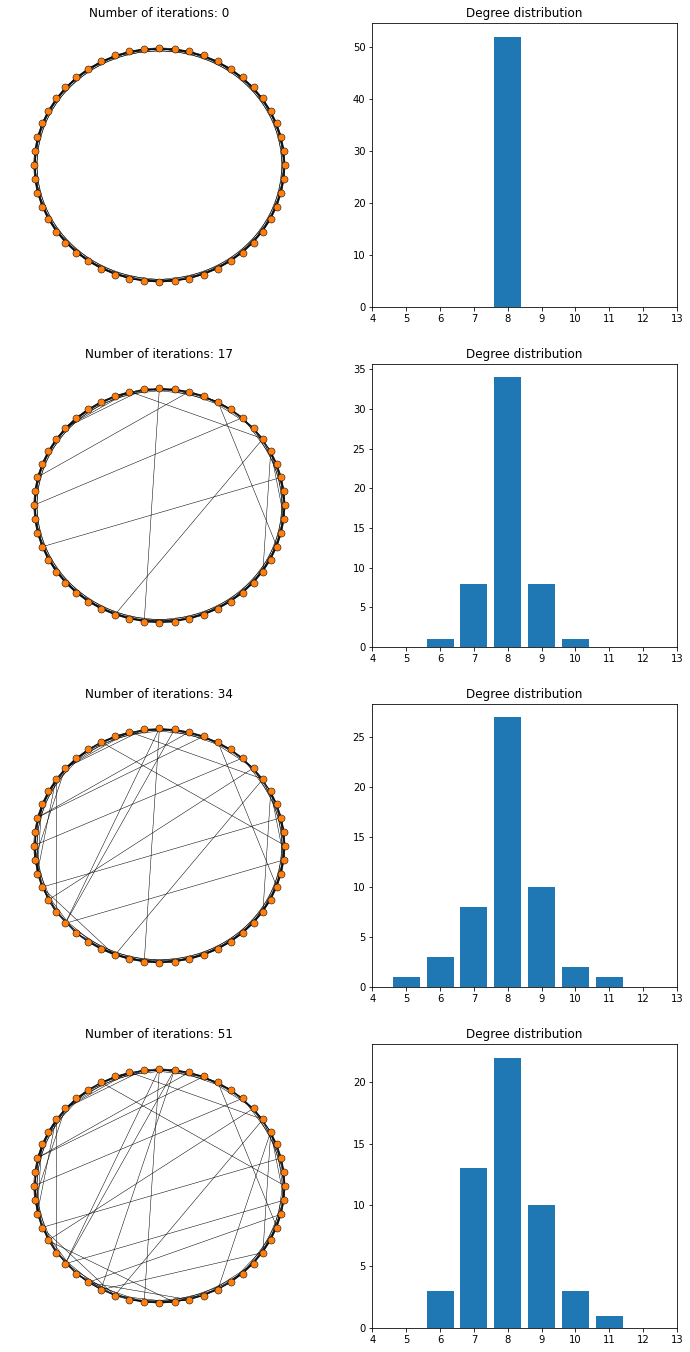

In [36]:
n, k, p = 52, 8, 0.2
G = ring_lattice(n, k)
plt.figure(figsize=(12, 6 * 4))
i = 1
for node in G.nodes:
    if node in np.arange(0, n+1, int(n/3)):
        plt.subplot(4, 2, i)
        plt.title('Number of iterations: {}'.format(node))
        nx.draw_circular(
            G,
            node_size=50, 
            width=0.5,
            linewidths=0.5,
            edgecolors='black',
            node_color='tab:orange')
        i += 1
        plt.subplot(4, 2, i)
        degree_seq = [degree for (node, degree) in G.degree]
        bins, freq = np.unique(degree_seq, return_counts=True)
        plt.bar(bins, freq)
        plt.xlim((4, 13))
        plt.title('Degree distribution')
        i += 1
    rewire(G, node, k, p)

### Task 7. Path lengths in small world (2 points)

Let us check that the average path length tends to theoretical value during building the small-world model.

$$\langle L \rangle = \begin{cases}
N/2k, \text{ if } p \to 0 \\
\log(N)/\log(k), \text{ if } p \to 1
\end{cases}$$

So that we have a lower and upper limits of path lengths for $0 < p < 1$.

Write a function `smallworld_path_len` with Watts-Strogatz model parameters `n, k, p` that returns np.array of average path lengths in each step (node). The length of the array is `n`.

*Hint: to calculate the average shortest path length, use `nx.average_shortest_path_length`*

In [37]:
def smallworld_path_len(n, k, p):
    # YOUR CODE HERE
    average_path = []
    G = ring_lattice(n, k)
    for node in G.nodes:
        rewire(G, node, k, p)
        average_path.append(nx.average_shortest_path_length(G))
    return np.array(average_path)
    # raise NotImplementedError()

In [38]:
n, k, p = 101, 10, 0.05
lengths = smallworld_path_len(n, k, p)
step_space = np.log(np.arange(1, len(lengths) + 1))
X = np.stack([step_space, np.ones(lengths.shape[0])], axis=1)
assert lengths.shape[0] == n
assert 0.1 < -(np.linalg.pinv(X) @ np.log(lengths))[0] < 0.25

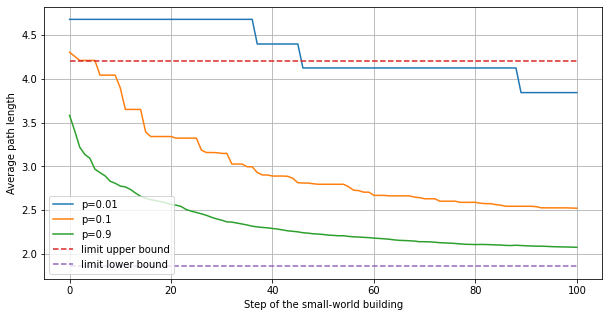

In [39]:
plt.figure(figsize=(10, 5))

n, k, p = 101, 12, 0.01
lengths = smallworld_path_len(n, k, p)
plt.plot(lengths, label=f'p={p}')

n, k, p = 101, 12, 0.1
lengths = smallworld_path_len(n, k, p)
plt.plot(lengths, label=f'p={p}')

n, k, p = 101, 12, 0.9
lengths = smallworld_path_len(n, k, p)
plt.plot(lengths, label=f'p={p}')

plt.xlabel('Step of the small-world building')
plt.ylabel('Average path length')
plt.grid()
plt.plot([0, 100], [n / 2 / k, n / 2 / k], '--', 
         label='limit upper bound')
plt.plot([0, 100], [np.log(n) / np.log(k), np.log(n) / np.log(k)], '--',
         label='limit lower bound')
plt.legend(loc='lower left')
plt.show()

### Task 8. Barabasi-Albert model (0 points)

Implement Barabasi-Albert model (preferential attachment model) – a growth process where each new node connects to `m` existing nodes. The higher node degree, the higher probability of the connection. The final number of nodes is `n`.

You start from a star graph with `m + 1` nodes. In each step you create `m` edges between a new node and existing nodes. The probability of connection to the node $i$ is 
$$p(i) = \frac{k_i}{\sum k}$$

Write a function `attach` that attaches a `node` to a graph `G` through `m` edges.

*Hint: Create a list with repeated nodes from a list of edges. For example, $[(1, 2), (2, 3), (2, 4)] \to [1, 2, 2, 3, 2, 4]$. Uniformly select nodes one-by-one. Apply `random.choice` instead of `np.random.choice` to speed up the generation.*

In [40]:
'''Do not touch the cell'''
def barabasi_albert_graph(n, m, random_seed=1):
    G = nx.star_graph(m)
    for i in range(1, n - m):
        attach(m + i, G, m)
    return G

In [41]:
def attach(node, G, m):
    # YOUR CODE HERE
    edges_parts = []
    for edge in G.edges: 
        edges_parts.extend(edge)
    targets = set()
    while len(targets) < m:
        targets.add(random.choice(edges_parts))
    for t in targets:
        G.add_edge(node, t)
    # raise NotImplementedError()

In [42]:
G = nx.star_graph(3)
attach(4, G, 3)
assert nx.number_of_edges(G) == 6

cases = [[10, 3], 
         [1000, 3], 
         [1000, 20]]
for n, m in cases:
    G = barabasi_albert_graph(n, m)
    degree_seq = [degree for (node, degree) in G.degree]
    nxG = nx.barabasi_albert_graph(n, m)
    nxdegree_seq = [degree for (node, degree) in nxG.degree]
    assert ks_2samp(degree_seq, nxdegree_seq).pvalue > 0.05

Let us see what the growth process looks like

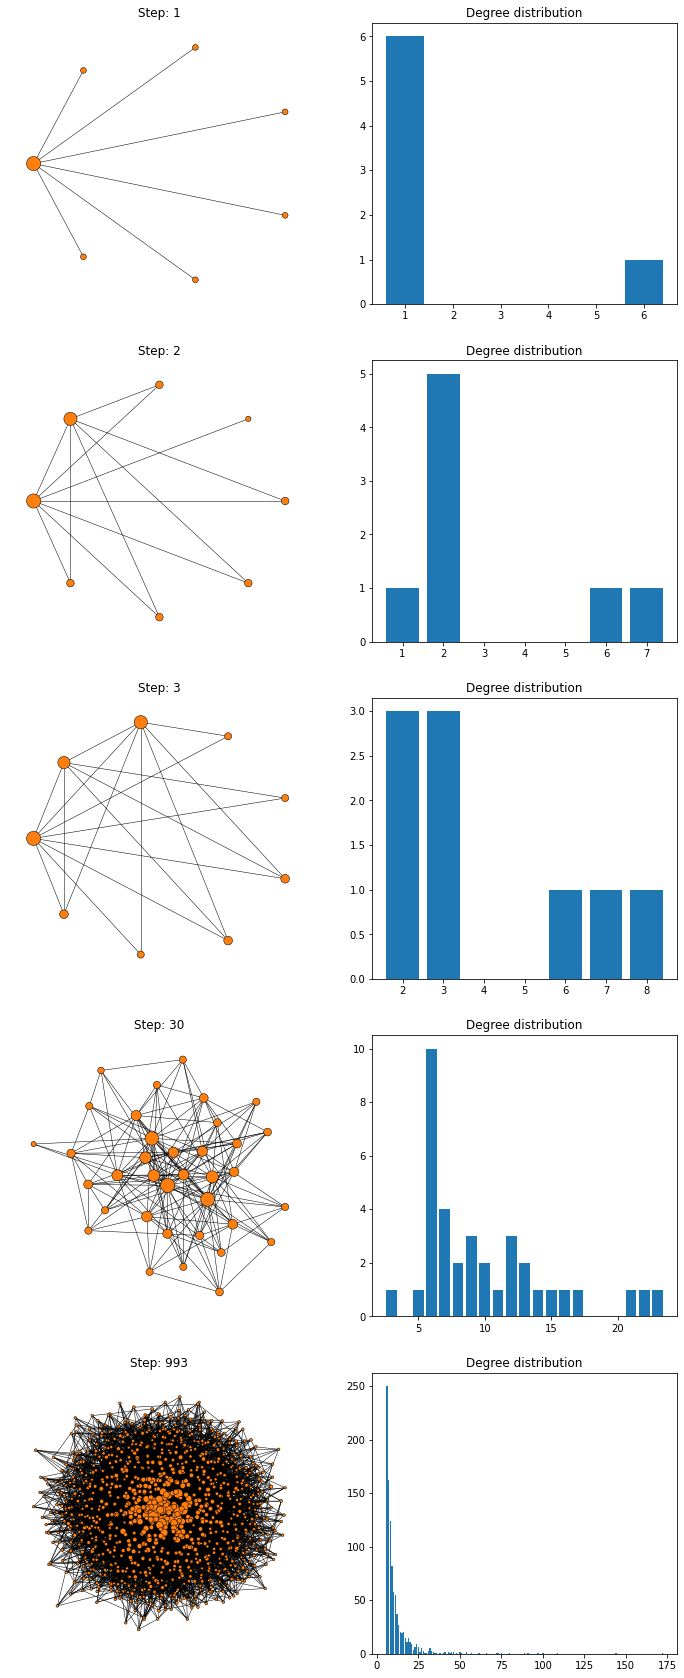

In [43]:
n, m = 1000, 6
G = nx.star_graph(m)
plt.figure(figsize=(12, 6 * 5))
j = 1
for i in range(1, n - m):
    if i in [1, 2, 3, 30, n-m-1]:
        plt.subplot(5, 2, j)
        j += 1
        sizes = np.array(list(nx.degree_centrality(G).values()))
        sizes = sizes / max(sizes) * 200
        if i <= 3:
            pos = nx.layout.shell_layout(G)
        else:
            pos = nx.layout.spring_layout(G)
        nx.draw(
            G,
            pos=pos,
            with_labels=False, 
            node_size=sizes, 
            width=0.5,
            linewidths=0.5,
            edgecolors='black',
            node_color='tab:orange')
        plt.title('Step: {}'.format(i))
        degree_seq = [degree for (node, degree) in G.degree]
        bins, freq = np.unique(degree_seq, return_counts=True)
        plt.subplot(5, 2, j)
        j += 1
        plt.bar(bins, freq)
        plt.title('Degree distribution')
    attach(m + i, G, m)

### Task 9. Degree distribution in preferential attachment (2 points)

Barabasi-Albert graph has a degree distribution of the form

$$P(k) = \frac{2m^2}{k^3}$$

That is Power law with $\alpha = 3$ and $k_\min = m$. 

Check this fact by an experiment — generate a set of Barabasi-Albert graphs and estimate parameters of Power law using MLE

$$\alpha = 1 + n \left[\sum_i \log \frac{k_i}{k_\min} \right]^{-1}$$

where the $k_\min$ is selected by minimal Kolmogorov-Smirnov distance between observed and theoretical distributions.

First, write a function `power_law_cdf` that takes an argument and parameters of the Power law distribution and returns the CDF.

In [44]:
def power_law_cdf(k, alpha=3.5, k_min=1):
    # YOUR CODE HERE
    return 1 - (k_min / k)**(alpha - 1)
    # raise NotImplementedError()

In [45]:
assert power_law_cdf(2, 2, 1) == 0.5
assert power_law_cdf(10, 2, 1) == 0.9

Next, write a function `mle_power_law_params` that takes a degree sequence and returns a tuple: the best $\alpha$, the best $k_\min$ w.r.t. MLE

_Hint: use `scipy.stats.kstest` where a theoretical CDF is a `power_law_cdf` function and `args=(alpha, k_min)`_

In [46]:
degree_sequence = np.array([1, 2, 3])
k_min = 2

In [47]:
degree_sequence / k_min

array([0.5, 1. , 1.5])

In [48]:
np.log(degree_sequence / k_min)

array([-0.69314718,  0.        ,  0.40546511])

In [49]:
np.sum(np.log(degree_sequence / k_min))

-0.2876820724517809

In [50]:
def mle_power_law_params(degree_sequence):
    # YOUR CODE HERE
    best_params = tuple()
    n = len(degree_sequence)
    KSTest_min = 1
    for i in range(n):
      k_min = degree_sequence[i]
      #alpha = 1
      #alpha_sum = 0
      #for j in range(n):
      #  alpha_sum += np.log(degree_sequence[j] / k_min)
      #alpha += n / alpha_sum
      alpha = 1 + n / np.sum(np.log(np.array(degree_sequence) / k_min))
      KSTest = st.kstest(rvs=degree_sequence, cdf=power_law_cdf, args=(alpha, k_min))
      if KSTest_min > KSTest.statistic:
        KSTest_min = KSTest.statistic
        best_params = (alpha, k_min)
    return best_params
    # raise NotImplementedError()

In [51]:
assert mle_power_law_params(np.array([1, 2, 3]))[0] > 0
assert mle_power_law_params(np.array([1, 2, 3]))[1] > 0

Write a function `estimate_power_law` that generates Barabasi-Albert graphs with `n` nodes, from `m_min` to `m_max` connections and returns a tuple of np.arrays: $\alpha$ and $k_{\min}$ for each graph.

In [52]:
def estimate_power_law(n, m_min, m_max):
    # YOUR CODE HERE
    alphas = []
    k_mins = []
    for m in range(m_min, m_max + 1):
      G = barabasi_albert_graph(n, m)
      degree_seq = [degree for (node, degree) in G.degree]
      alpha, k_min = mle_power_law_params(degree_seq)
      alphas.append(alpha)
      k_mins.append(k_min)
    return np.array(alphas), np.array(k_mins)
    # raise NotImplementedError()

In [53]:
'''Check the Power law parameters'''
n, m_min, m_max = 500, 2, 20
alpha, k_min = estimate_power_law(n, m_min, m_max)
assert alpha.shape[0] == m_max - m_min + 1
assert 2 < alpha.mean() < 4
assert k_min[0] < k_min[-1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


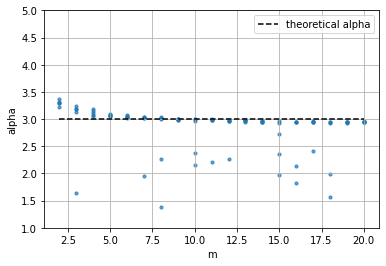

In [54]:
n, m_min, m_max = 500, 2, 20
m_space = np.arange(m_min, m_max + 1)
for _ in range(5):
    alpha, k_min = estimate_power_law(n, m_min, m_max)
    plt.scatter(m_space, alpha, alpha=0.7, c='tab:blue', s=10)
plt.plot([2, 20], [3, 3], 'k--', label='theoretical alpha')
plt.ylim((1, 5))
plt.xlabel('m')
plt.ylabel('alpha')
plt.grid()
plt.legend()
plt.show()

### Task 10. Degree dynamics in preferential attachment (2 points)

Measure the degree dynamics in Barabasi-Albert model of one of the initial nodes and of the nodes added to the network at intermediate time moments (steps of the algorithm).

Write a function `generate_degree_dynamics` that takes np.array with considered nodes, generates Barabasi-Albert graph ($n=3000$, $m=6$) and returns a np.array of the shape `(29, len(nodes))` — degrees of these nodes at time moments 100, 200, 300, ..., 2900. If the node does not exist yet, pass `np.nan` value.

*Hint: use the `barabasi_albert_graph` function as a template*

In [55]:
def generate_degree_dynamics(cons_nodes):
    # YOUR CODE HERE
    n = 3000
    m = 6
    result = []
    G = nx.star_graph(m)
    for i in range(1, n - m):
        attach(m + i, G, m)
        if i % 100 == 0 and i != 0:
          step_result = []
          degree_seq = [degree for (node, degree) in G.degree]
          node_seq = [node for (node, degree) in G.degree]
          for node in cons_nodes:
            if node in node_seq:
              step_result.append(degree_seq[node])
            else:
              step_result.append(np.nan)
          result.append(step_result)
    return np.array(result)
    # raise NotImplementedError()

In [56]:
degree_dynamics = generate_degree_dynamics([0, 100, 700, 2000])
assert degree_dynamics.shape == (29, 4)
assert np.all(np.isnan(degree_dynamics[0]) == [False, False,  True,  True])
assert np.all(np.isnan(degree_dynamics[9]) == [False, False,  False,  True])
assert degree_dynamics[0, 0] < degree_dynamics[-1, 0]
assert degree_dynamics[0, 1] < degree_dynamics[-1, 1]
assert degree_dynamics[-1, 0] > degree_dynamics[-1, 3]

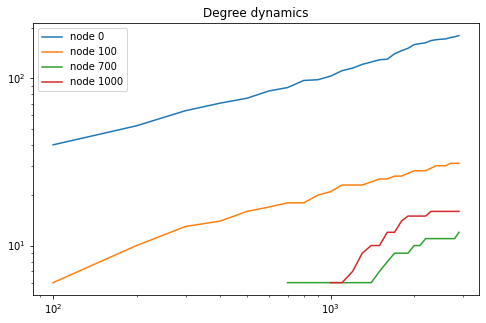

In [57]:
degree_dynamics = generate_degree_dynamics([0, 100, 700, 1000])
plt.figure(figsize=(8, 5))
time_space = np.tile(np.arange(100, 3000, 100), (4, 1)).T
plt.plot(time_space, degree_dynamics)
plt.legend(['node 0', 'node 100', 'node 700', 'node 1000'])
plt.title('Degree dynamics')
plt.xscale('log')
plt.yscale('log')
plt.show()